<a href="https://colab.research.google.com/github/bijanf/ESD_Workshop/blob/main/Downscaling_Workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A notebkook to demonstrate the statistical downscaling of CMIP6-like simulations

- by Bijan Fallah, PIK

- Workshop 2023 October in tashkent
- We use the ISIMIP3a input data at 0.5 degree and downscale them using the CHELSA observation to 1 km
- We show the result for tas first and it could be extended to pr


In [ ]:
print("Bijan Fallah")
# it just prints my name

Bijan Fallah


In [ ]:
# import libraries:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")  # sklearn
import matplotlib.pyplot as plt
import seaborn as sns
#!./myenv/bin/pip xarray[complete]
import pandas as pd
import os
!pip install scikit-downscale
from skdownscale.pointwise_models import BcsdTemperature, BcsdPrecipitation
import xarray as xr
from tqdm import tqdm
import numpy as np

!pip install cmocean
import cmocean
sns.set(style='darkgrid')
from skdownscale.pointwise_models import PointWiseDownscaler
!pip install --upgrade --no-cache-dir gdown
import gdown

In [ ]:
help(xr)

Help on package xarray:

NAME
    xarray

PACKAGE CONTENTS
    backends (package)
    coding (package)
    conventions
    convert
    core (package)
    indexes (package)
    plot (package)
    static (package)
    testing
    tests (package)
    tutorial
    util (package)

CLASSES
    builtins.RuntimeWarning(builtins.Warning)
        xarray.coding.variables.SerializationWarning
    builtins.ValueError(builtins.Exception)
        xarray.core.merge.MergeError
    builtins.object
        xarray.core.merge.Context
        xarray.core.options.set_options
    collections.abc.Mapping(collections.abc.Collection)
        xarray.core.dataset.Dataset(xarray.core.common.DataWithCoords, xarray.core._aggregations.DatasetAggregations, xarray.core.arithmetic.DatasetArithmetic, collections.abc.Mapping)
    pandas.core.indexes.base.Index(pandas.core.base.IndexOpsMixin, pandas.core.base.PandasObject)
        xarray.coding.cftimeindex.CFTimeIndex
    xarray.core._aggregations.DataArrayAggregations(buil

In [ ]:
# Downloading the datasets:
os.system("gdown --folder https://drive.google.com/drive/folders/1fBqc707FVyVWXM5L4tSBKMZsWFEjjH-J?usp=sharing")

0

In [ ]:
test = xr.open_dataset("/content/worshop_20years/chelsa_CA_1980_tashkent.nc")

In [ ]:
era =xr.open_dataset("/content/ERA5.nc")

In [ ]:
era

<xarray.Dataset>
Dimensions:    (lat: 360, lon: 720)
Coordinates:
  * lat        (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lon        (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
Data variables:
    crs        |S1 ...
    tas_trend  (lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.9 (https://mpimet.mpg.de...
    CDO:          Climate Data Operators version 1.9.9 (https://mpimet.mpg.de...
    Conventions:  CF-1.5
    history:      Wed Oct 25 05:33:56 2023: GDAL CreateCopy( /tmp/NETCDF___ta...
    Origin:       NetCDF file created by loadeR.2nc: https://github.com/Santa...
    GDAL:         GDAL 1.11.4, released 2016/01/25

In [ ]:
1985 - 02 - 25

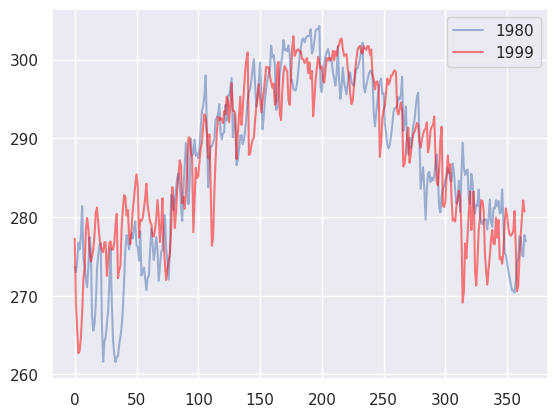

In [ ]:
file_1 = xr.open_dataset("/content/worshop_20years/chelsa_CA_1980_tashkent.nc")
file_2 = xr.open_dataset("/content/worshop_20years/chelsa_CA_1999_tashkent.nc")

# select the first time step
test1 = file_1.mean(dim=['lon','lat'])
#test1.tas.plot(label='1980',color='red')
plt.plot(test1.tas,color='b',label='1980',alpha=0.5)
test2 = file_2.mean(dim=['lon','lat'])
plt.plot(test2.tas,color='red',label='1999',alpha=0.5)

#test2.tas.plot(label='1999')

#test1.tas.plot()
#plt.title("differences between 2 years in °C ")
#plt.ylabel("Lat")
#plt.xlabel("Lon")
plt.legend()
plt.savefig("time_series_1980.png",dpi=300)

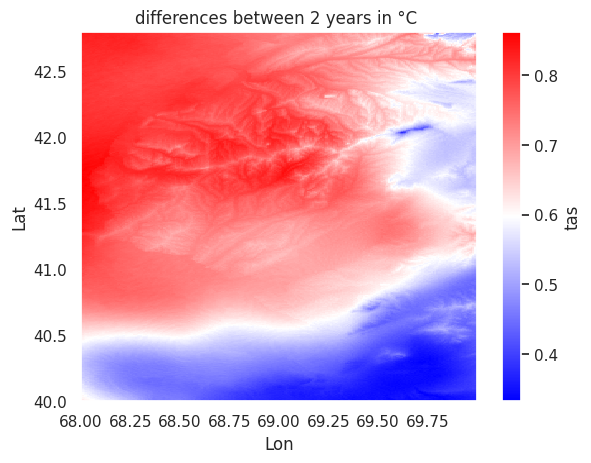

In [ ]:
file_1 = xr.open_dataset("/content/worshop_20years/chelsa_CA_1980_tashkent.nc")
file_2 = xr.open_dataset("/content/worshop_20years/chelsa_CA_1999_tashkent.nc")

# select the first time step
test1 = file_2.mean(dim='time') - file_1.mean(dim='time')
test1.tas.plot.pcolormesh(x="lon", y="lat", cmap="bwr", add_colorbar=True,
                          add_labels=True)
plt.title("differences between 2 years in °C ")
plt.ylabel("Lat")
plt.xlabel("Lon")
plt.savefig("diff_years.png",dpi=300)


In [ ]:
file_2

<xarray.Dataset>
Dimensions:  (time: 365, lon: 240, lat: 336)
Coordinates:
  * time     (time) datetime64[ns] 1999-01-01 1999-01-02 ... 1999-12-31
  * lon      (lon) float64 68.0 68.01 68.02 68.03 ... 69.97 69.98 69.99 70.0
  * lat      (lat) float64 40.0 40.01 40.02 40.03 ... 42.77 42.78 42.79 42.8
Data variables:
    tas      (time, lat, lon) float32 278.9 278.9 278.9 ... 274.2 273.9 274.0
Attributes: (12/14)
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  Potsdam Institute for Climate Impact Research (PIK) and Swi...
    title:        CHELSA-W5E5 v1.0: W5E5 v1.0 downscaled with CHELSA v2.0
    project:      Inter-Sectoral Impact Model Intercomparison Project phase 3...
    contact:      ISIMIP cross-sectoral science team <info@isimip.org> <https...
    ...           ...
    caution:      In contrast to the ISIMIP standard, latitude values in this...
    comment:      Values of tas in this file are packed for storage reasons; ...
    isimip_id:    a8ef62c3-c857-480a-9859-8249da3d2bf9
    history:      Sat Oct 21 13:34:08 2023: cdo mergetime chelsa_CA_199901_ta...
    NCO:          netCDF Operators version 4.7.8 (Homepage = http://nco.sf.ne...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...

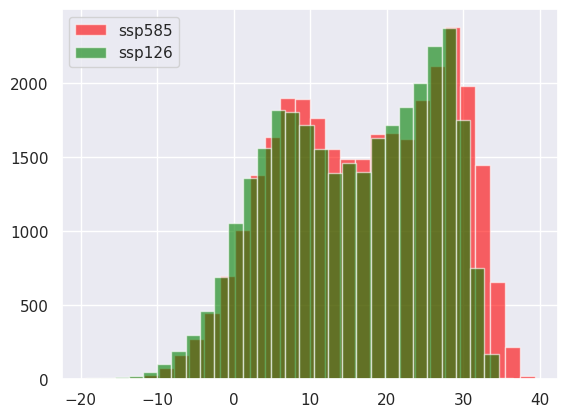

In [ ]:
data = xr.open_dataset("/content/worshop_20years/mpi-esm1-2-hr_r1i1p1f1_w5e5_tas_ssp585_tashkent.nc")
#data.tas.mean(dim=['lon','lat']).plot()
data2 = xr.open_dataset("/content/worshop_20years/mpi-esm1-2-hr_r1i1p1f1_w5e5_tas_ssp126_tashkent.nc")
#data2.tas.mean(dim=['lon','lat']).plot()
plt.hist(data.tas.mean(dim=['lon','lat'])- 273.15, 30, color='red', label='ssp585', alpha=.6)
plt.hist(data2.tas.mean(dim=['lon','lat'])- 273.15, 30, color='green', label='ssp126', alpha=.6)
plt.legend()

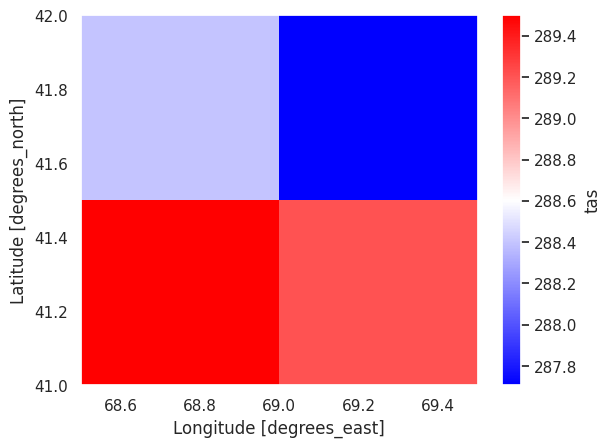

In [ ]:
data2['tas'].mean(dim='time').plot.pcolormesh(x="lon", y="lat", cmap="bwr", add_colorbar=True,
                          add_labels=True)

In [ ]:
# parameters
train_slice = slice('1980', '1999')  # train time range
#holdout_slice = slice('2015', '2044')  # prediction time range
holdout_slice = slice('2080', '2099')  # prediction time range
# bounding box of downscaling region
# region:
city="tashkent"
lat0=41.25
lat1=41.75
lon0=68.75
lon1=69.25


ssp="ssp585" # ssp126 ssp370
var="tas"
lon_slice = slice(lon0, lon1) #90
lat_slice = slice(lat0, lat1) #60

In [ ]:
# chunk shape for dask execution (time must be contiguous, ie -1)
chunks = {'lat': 10, 'lon': 10, 'time': -1}


In [ ]:
# Read gridded Observation dataset:
fnames = [f'/content/worshop_20years/chelsa_CA_{year}_tashkent.nc'
for year in range(int(train_slice.start), int(train_slice.stop) + 1)]
obs = xr.open_mfdataset(fnames, engine='h5netcdf', concat_dim='time',combine='nested')

#obs =xr.open_mfdataset(['/content/worshop_20years/chelsa_CA_1980_tashkent.nc',
#                        '/content/worshop_20years/chelsa_CA_1981_tashkent.nc',
#                        '/content/worshop_20years/chelsa_CA_1981_tashkent.nc',
#                        ], engine='h5netcdf', concat_dim='time',combine='nested')

# Select the latitude and longitude and make daily averages:
obs_subset = obs[var].sel(time=train_slice, lon=lon_slice, lat=lat_slice).resample(time='1d').mean().load(scheduler='threads').chunk(chunks)

In [ ]:
# Read the future scenario file:
ssp = xr.open_dataset('/content/worshop_20years/mpi-esm1-2-hr_r1i1p1f1_w5e5_tas_'+ssp+'_tashkent.nc', engine='h5netcdf')
ds_model_ssp = ssp[var].squeeze(drop=True)
ds_model_ssp = ds_model_ssp.reindex(lat=ds_model_ssp.lat[::-1])
# read the historical simulation file:
hist = xr.open_dataset('/content/worshop_20years/mpi-esm1-2-hr_r1i1p1f1_w5e5_historical_tas_tashkent.nc', engine='h5netcdf')
ds_model_hist = hist[var].squeeze(drop=True)
ds_model_hist = ds_model_hist.reindex(lat=ds_model_hist.lat[::-1])


In [ ]:
#interpolat the simulation to the observation grid:
train_subset = ds_model_hist.sel(time=train_slice).interp_like(obs_subset.isel(time=0,drop=True), method='linear')

In [ ]:
# select the same time axis
train_subset['time'] = pd.to_datetime(train_subset.indexes['time'])
train_subset = train_subset.resample(time='1d').mean().load(scheduler='threads').chunk(chunks)
# romove nan values if any:
train_subset = train_subset.dropna(dim="time", how="any")
obs_subset_new = obs_subset.sel(time=train_subset.time)

In [ ]:
# same preprocessing also for the future scenarios:
holdout_subset = ds_model_ssp.sel(time=holdout_slice).interp_like(obs_subset.isel(time=0,
                                                                                           drop=True), method='linear')
holdout_subset['time'] = pd.to_datetime(holdout_subset.indexes['time'])
holdout_subset = holdout_subset.resample(time='1d').mean().load(scheduler='threads').chunk(chunks)

In [ ]:
##########################################################
#               Train the model
##########################################################
model = PointWiseDownscaler(BcsdTemperature(return_anoms=False))
   #    model
#train_subset = train_subset.fillna(-9999)
#obs_subset = obs_subset.fillna(-9999)
# train the model for 1980 - 1999
model.fit(train_subset, obs_subset_new)


##########################################################
#               peredict
##########################################################
holdout_subset = holdout_subset.dropna(dim="time", how="any")

print(holdout_subset.shape)
print('-------------------')
print()
print()
predicted = model.predict(holdout_subset).load()


##########################################################
#               Save the results
##########################################################
#name = 'predicted_'+str(int(holdout_slice.start))+'_'+str(int(holdout_slice.stop))+'_'+ssp+'.nc'
predicted.to_netcdf("prediction_ssp585.nc")

(7305, 60, 60)
-------------------




In [ ]:
predicted.to_netcdf("prediction_ssp.nc")

## Poltting the Results

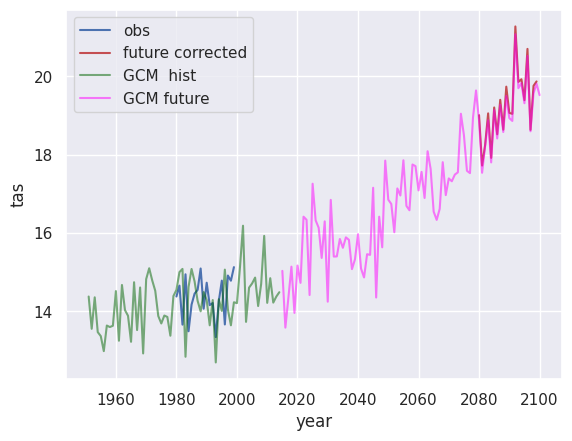

In [ ]:
def plot_yearly_mean(file, color, alpha, label):
  # Calculate the mean value over all lon and lat values
  mean_tas = file.mean(dim=['lon', 'lat'])
  # Group by year and take the mean
  yearly_mean = mean_tas.groupby('time.year').mean() -273.15
  # Plot the monthly mean as a line chart
  yearly_mean.plot(color=color, alpha=alpha, label = label)
  plt.legend()

plot_yearly_mean(obs_subset, "b",1,'obs')
plot_yearly_mean(predicted, "r",1,'future corrected')
plot_yearly_mean(ds_model_hist, "darkgreen",.5,"GCM  hist")
plot_yearly_mean(ds_model_ssp, "magenta", .5, "GCM future")
plt.savefig("time_series.png", dpi=250)


### Seasonal plot

In [ ]:
def plot_seasonal_mean(file,season , color, alpha, label):

  # Calculate the mean value over all lon and lat values
  mean_tas = file.mean(dim=['lon', 'lat'])
  # Group by season and year and take the mean
  if season == "JJA":
    season_mean = mean_tas.where(mean_tas.time.dt.month.isin([6, 7, 8]), drop=True).groupby('time.year').mean() - 273.15
  if season == "DJF":
    season_mean = mean_tas.where(mean_tas.time.dt.month.isin([12, 1, 2]), drop=True).groupby('time.year').mean() - 273.15

  # Plot the monthly mean as a line chart
  season_mean.plot(color=color, alpha=alpha, label = label)

  plt.legend()

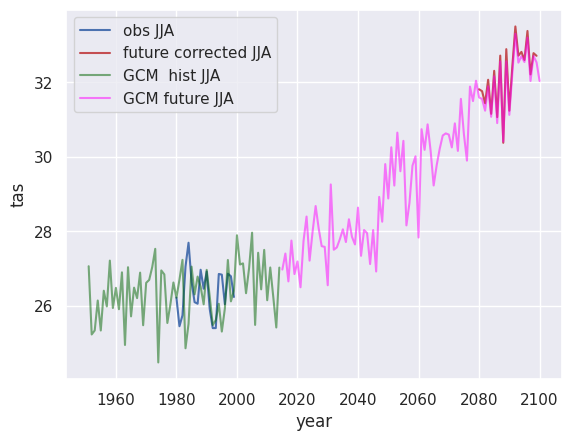

In [ ]:
plot_seasonal_mean(obs_subset, "JJA","b",1,'obs JJA')
plot_seasonal_mean(predicted, "JJA", "r",1,'future corrected JJA')
plot_seasonal_mean(ds_model_hist, "JJA", "darkgreen",.5,"GCM  hist JJA")
plot_seasonal_mean(ds_model_ssp, "JJA", "magenta", .5, "GCM future JJA")
plt.savefig("time_sefies_JJA.png", dpi=250)

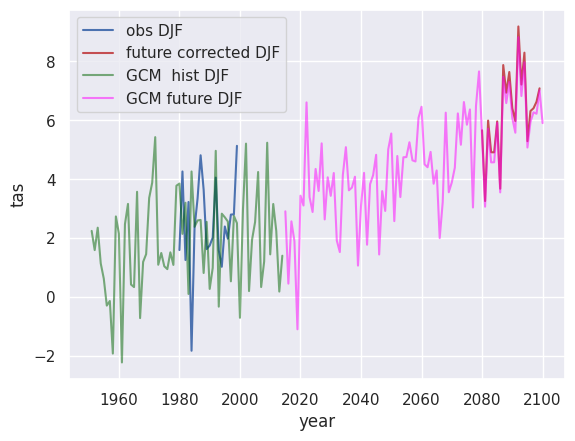

In [ ]:
plot_seasonal_mean(obs_subset, "DJF","b",1,'obs DJF')
plot_seasonal_mean(predicted, "DJF", "r",1,'future corrected DJF')
plot_seasonal_mean(ds_model_hist, "DJF", "darkgreen",.5,"GCM  hist DJF")
plot_seasonal_mean(ds_model_ssp, "DJF", "magenta", .5, "GCM future DJF")


plt.savefig("time_sefies_JJA.png", dpi=250)

In [ ]:
obs_subset

<xarray.DataArray 'tas' (time: 7305, lat: 60, lon: 60)>
dask.array<where, shape=(7305, 60, 60), dtype=float32, chunksize=(7305, 10, 10), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 68.75 68.76 68.77 68.78 ... 69.22 69.23 69.24 69.25
  * lat      (lat) float64 41.25 41.26 41.27 41.28 ... 41.72 41.73 41.74 41.75
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 1999-12-31
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    units:          K

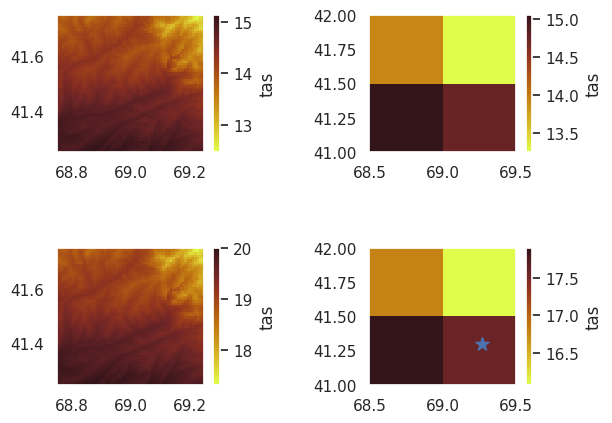

<Figure size 640x480 with 0 Axes>

In [ ]:
# Calculate the time average for each data array
obs_subset_mean = obs_subset.mean(dim='time') -273.15
ds_model_hist_mean = ds_model_hist.sel(time=train_slice).mean(dim='time') -273.15
predicted_mean = predicted.mean(dim='time')-273.15
ds_model_ssp_mean = ds_model_ssp.mean(dim='time')-273.15

# Plot the time average as a pcolormesh for each data array
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2)
obs_subset_mean.plot.pcolormesh(ax=ax1,x="lon", y="lat",cmap=cmocean.cm.solar_r)#, vmin=15, vmax=20)
ds_model_hist_mean.plot.pcolormesh(ax=ax2,x="lon", y="lat",cmap=cmocean.cm.solar_r)#, vmin=15, vmax=20)
predicted_mean.plot.pcolormesh(ax=ax3,x="lon", y="lat",cmap=cmocean.cm.solar_r)#, vmin=15, vmax=20)
ds_model_ssp_mean.plot.pcolormesh(ax=ax4,x="lon", y="lat",cmap=cmocean.cm.solar_r)#, vmin=15, vmax=20)

# Plot the coordinates of Tashkent with a star marker
ax4.scatter(69.2666656, 41.2999988 , marker="*", color="b", s=100)

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.7, wspace=0.7)
ax1.set_xlabel('')
#ax1.set_title('Observation')

ax2.set_xlabel('')
ax3.set_xlabel('')
ax4.set_xlabel('')

ax1.set_ylabel('')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax4.set_ylabel('')

plt.show()
plt.savefig("Maps.png", dpi=250)

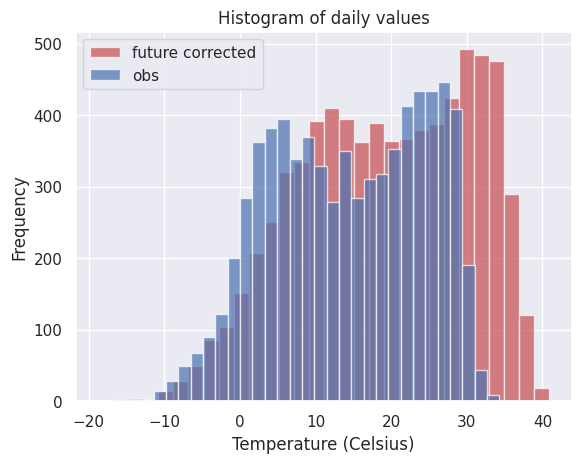

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

def plot_histogram(file, color, alpha, label):
  # Get the array of daily values
  daily_values = file.mean(dim=['lon', 'lat']).values - 273.15
  # Plot the histogram of daily values
  plt.hist(daily_values, bins=30, color=color, alpha=alpha, label=label)
  plt.legend()
plot_histogram(predicted, "r",.71,'future corrected')
plot_histogram(obs_subset, "b",.71,'obs')

#plot_histogram(ds_model_hist, "darkgreen",.5,"GCM  hist")
#plot_histogram(ds_model_ssp, "magenta", .5, "GCM future")

# Set the x-axis label
plt.xlabel('Temperature (Celsius)')

# Set the y-axis label
plt.ylabel('Frequency')

# Set the title
plt.title('Histogram of daily values')

plt.show()
plt.savefig("histograms.png", dpi=250)

### Plot a randome netcdf file

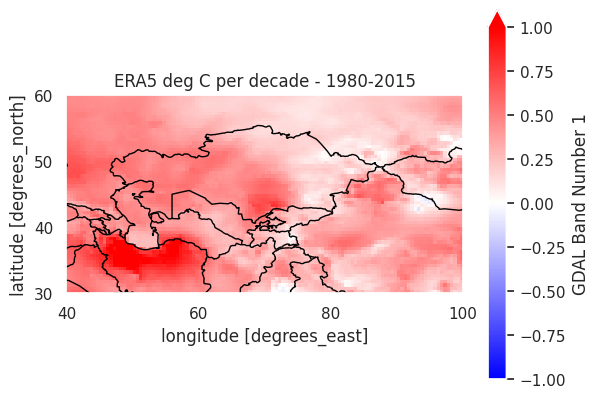

In [ ]:
#!pip install cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf
#####test = xr.open_dataset("ERA5.nc")
lon_slice = slice(40,100)
lat_slice = slice(30,60)
test_tas = era.tas_trend.sel(lon=lon_slice, lat=lat_slice)
ax = plt.axes(projection=ccrs.PlateCarree())
# potting thr data
test_tas.plot.pcolormesh(x="lon", y="lat", cmap="bwr", add_colorbar=True,add_labels=True,
                         transform=ccrs.PlateCarree(), xticks=[ 40, 60, 80, 100],
                         yticks=[30, 40, 50, 60], vmin=-1, vmax = 1)
plt.title('ERA5 deg C per decade - 1980-2015')
ax.add_feature(cf.BORDERS)
ax.add_feature(cf.COASTLINE)
plt.savefig("era5_example.png", dpi=300)

In [ ]:
kfo = xr.open_dataset("/content/ca_water_ssp585_30_2021-2100_p50_regions_1.nc")

In [ ]:
kfo

<xarray.Dataset>
Dimensions:     (time: 6, ID: 1)
Coordinates:
  * time        (time) datetime64[ns] 2035-07-08 2045-07-08 ... 2085-07-08
  * ID          (ID) object 'Central Asia'
Data variables:
    evap-total  (time, ID) float64 ...
    name        (ID) object ...
    potevap     (time, ID) float64 ...
    qtot        (time, ID) float64 ...
    swe         (time, ID) float64 ...
Attributes:
    history:  2023-09-19-10:42:14 added var values based on mask file ./tmp/5...

In [ ]:
lon_slice = slice(40,100)
lat_slice = slice(30,60)
test_tas = kfo['evap-total'].sel(lon=lon_slice, lat=lat_slice)
ax = plt.axes(projection=ccrs.PlateCarree())
# potting thr data
test_tas.plot.pcolormesh(x="lon", y="lat", cmap="bwr", add_colorbar=True,add_labels=True,
                         transform=ccrs.PlateCarree(), xticks=[ 40, 60, 80, 100],
                         yticks=[30, 40, 50, 60], vmin=-1, vmax = 1)
plt.title('ERA5 deg C per decade - 1980-2015')
ax.add_feature(cf.BORDERS)
ax.add_feature(cf.COASTLINE)

KeyError: ignored

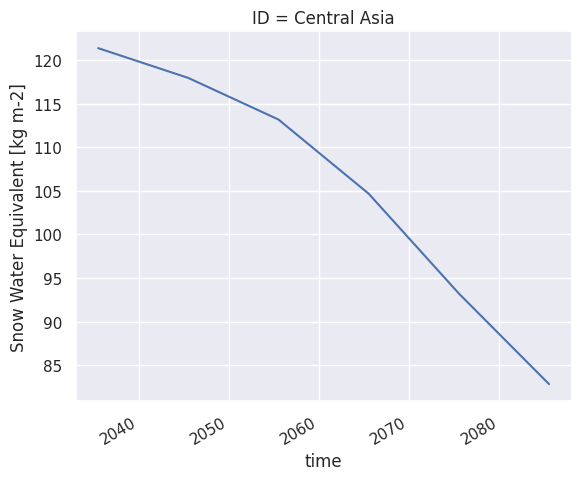

In [ ]:
kfo['swe'].plot()


In [ ]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
!pip install meteostat
from meteostat import Stations, Hourly, Daily
from datetime import datetime,date , timedelta
import numpy as np

In [ ]:
# Set time period
start = datetime(1894, 1, 1)
yesterday = date.today() - timedelta(days = 1)
end = datetime(yesterday.year, yesterday.month, yesterday.day, 23, 59)

# Get the daily data for the station
# Get nearby weather stations
# The list of the climate station could be found for Germany here : https://www.dwd.de/DE/leistungen/klimadatendeutschland/stationsuebersicht.html?nn=16102&lsbId=343278

stations = Stations()
stations = stations.nearby( 52.382,13.062) # where the station is located !
station = stations.fetch(1) # fetch the first nearest station

# Print DataFrame
print(station)
print(yesterday.year)

# Get hourly data
data = Hourly('10379', start, end)
data = data.fetch()

# Print DataFrame
data.tail()

          name country region    wmo  icao  latitude  longitude  elevation  \
id                                                                           
10379  Potsdam      DE     BB  10379  <NA>   52.3833    13.0667       81.0   

            timezone hourly_start hourly_end daily_start  daily_end  \
id                                                                    
10379  Europe/Berlin   1893-01-01 2023-10-23  1893-01-01 2023-10-21   

      monthly_start monthly_end    distance  
id                                           
10379    1893-01-01  2022-01-01  350.221116  
2023


,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2023-10-24 19:00:00,11.9,11.7,99.0,0.1,0.0,210.0,3.0,10.0,1003.3,0.0,8.0
2023-10-24 20:00:00,11.9,11.7,99.0,0.5,0.0,230.0,4.0,5.0,1003.2,0.0,8.0
2023-10-24 21:00:00,11.8,11.6,99.0,1.0,0.0,220.0,4.0,8.0,1002.9,0.0,7.0
2023-10-24 22:00:00,11.7,11.5,99.0,0.0,0.0,230.0,7.0,9.0,1002.7,0.0,5.0
2023-10-24 23:00:00,11.5,11.3,99.0,0.0,0.0,240.0,8.0,13.0,1002.6,0.0,5.0


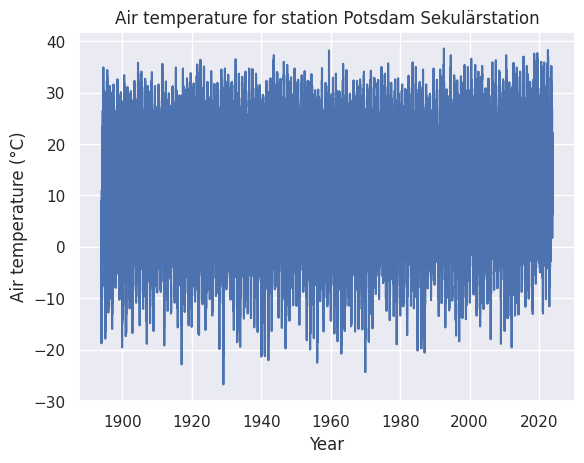

In [ ]:
# Plot the hourly temperature
plt.plot(data["temp"])
plt.xlabel("Year")
plt.ylabel("Air temperature (°C)")
plt.title("Air temperature for station Potsdam Sekulärstation")
plt.show()

In [ ]:
data['temp'].to_csv('temperature_potsdam.csv')

In [ ]:
data.temp.shape

(1137912,)

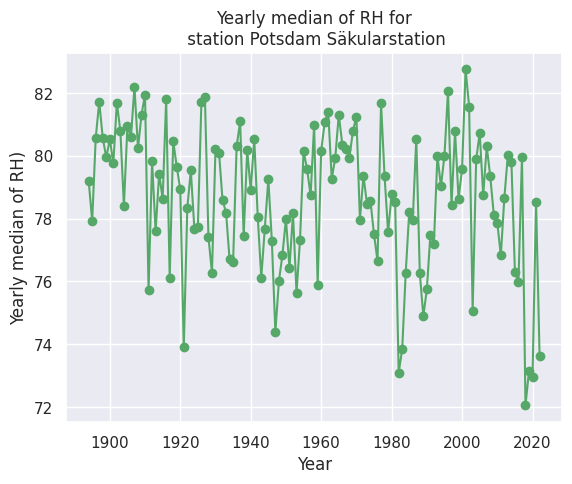

In [ ]:
# Group the data by year and get the median
yearly_median = data.groupby(data.index.year)["rhum"].mean()

# Plot the yearly median of relative humidity
plt.plot(yearly_median[:-1],'g-o')# ignore this year because it is not completed!
plt.xlabel("Year")
plt.ylabel("Yearly median of RH)")
plt.title("Yearly median of RH for\n station Potsdam Säkularstation")
plt.show()

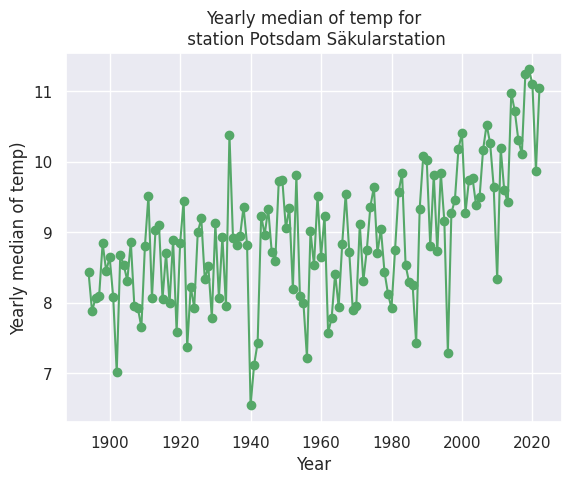

In [ ]:
# Group the data by year and get the median
yearly_median = data.groupby(data.index.year)["temp"].mean()

# Plot the yearly median of relative humidity
plt.plot(yearly_median[:-1],'g-o')# ignore this year because it is not completed!
plt.xlabel("Year")
plt.ylabel("Yearly median of temp)")
plt.title("Yearly median of temp for\n station Potsdam Säkularstation")
plt.show()

In [ ]:
#69.2666656, 41.2999988
from meteostat import Stations, Hourly


In [ ]:
stations = Stations()
stations = stations.nearby(41.2999988, 69.2666656) # where the station is located !
station = stations.fetch(20) # fetch the first nearest station

# Print DataFrame
print(station)




                                             name country region    wmo  icao  \
id                                                                              
38457                                    Tashkent      UZ     TK  38457  UTTT   
38583                                  Syr-Dar'Ja      UZ     SI  38583  <NA>   
38468                                   Kok-Saray      UZ     TA  38468  <NA>   
38444                               Koksu / Köks?      KZ    YUZ  38444  <NA>   
38439                                     Cardara      KZ    YUZ  38439  <NA>   
38462                                       Pskem      UZ     TA  38462  <NA>   
38328                                    Shymkent      KZ    YUZ  38328  UAII   
38598  Kajrakkumskoe Vodohranilishche / Qayroqqum      TJ     LE  38598  <NA>   
38589                                     Jangier      UZ     SI  38589  <NA>   
UTDL0                         Khudzhand / Chkalov      TJ     LE   <NA>  UTDL   
38599                       

In [ ]:
# Get hourly data
data_2 = Hourly('38457', start, end)
data_2 = data_2.fetch()

# Print DataFrame
data_2.tail()

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2023-10-24 19:00:00,13.0,4.9,58.0,0.0,NaN,40.0,11.0,NaN,1016.0,NaN,1.0
2023-10-24 20:00:00,12.0,4.0,58.0,0.0,NaN,70.0,7.0,NaN,1016.0,NaN,1.0
2023-10-24 21:00:00,11.0,4.0,62.0,0.0,NaN,60.0,7.0,NaN,1016.0,NaN,1.0
2023-10-24 22:00:00,10.0,3.1,62.0,0.0,NaN,60.0,4.0,NaN,1015.0,NaN,1.0
2023-10-24 23:00:00,11.0,3.0,58.0,0.0,NaN,210.0,7.0,NaN,1016.0,NaN,1.0


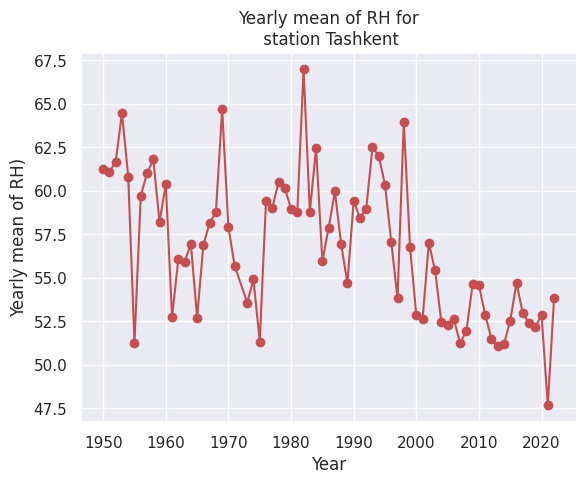

In [ ]:
# Group the data by year and get the median
yearly_median = data_2.groupby(data_2.index.year)["rhum"].mean()

# Plot the yearly median of relative humidity
plt.plot(yearly_median[:-1],'r-o')# ignore this year because it is not completed!
plt.xlabel("Year")
plt.ylabel("Yearly mean of RH)")
plt.title("Yearly mean of RH for\n station Tashkent")
plt.show()

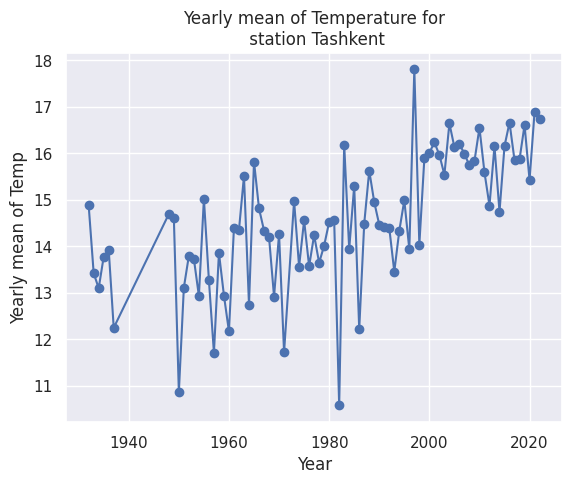

In [ ]:
# Group the data by year and get the median
yearly_median = data_2.groupby(data_2.index.year)["temp"].mean()

# Plot the yearly median of relative humidity
plt.plot(yearly_median[:-1],'b-o')# ignore this year because it is not completed!
plt.xlabel("Year")
plt.ylabel("Yearly mean of Temp")
plt.title("Yearly mean of Temperature for\n station Tashkent")
plt.show()

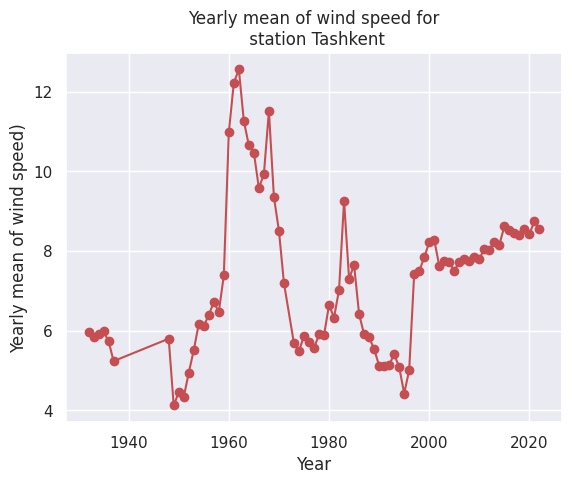

In [ ]:
# Group the data by year and get the median
yearly_median = data_2.groupby(data_2.index.year)["wspd"].mean()

# Plot the yearly median of relative humidity
plt.plot(yearly_median[:-1],'r-o')# ignore this year because it is not completed!
plt.xlabel("Year")
plt.ylabel("Yearly mean of wind speed)")
plt.title("Yearly mean of wind speed for\n station Tashkent")
plt.show()

In [ ]:
yearly_median.to_excel("test_data.xlsx")

In [ ]:
yearly_median

time
1932    14.882307
1933    13.423133
1934    13.100635
1935    13.777647
1936    13.929599
          ...    
2019    16.610868
2020    15.427186
2021    16.895765
2022    16.731416
2023    18.941863
Name: temp, Length: 81, dtype: float64

In [ ]:
obs.lon

<xarray.DataArray 'lon' (lon: 240)>
array([68.004027, 68.01236 , 68.020693, ..., 69.979027, 69.98736 , 69.995693])
Coordinates:
  * lon      (lon) float64 68.0 68.01 68.02 68.03 ... 69.97 69.98 69.99 70.0
Attributes:
    standard_name:  longitude
    long_name:      Longitude
    units:          degrees_east
    axis:           X